# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 05 : Analyse spatiale et temporelle 


### Identité du document
* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 31 Décembre 2025
* **Dernière mise à jour :** 04 Janvier 2026
* **Dépendances notebooks**: Notebook 0,1,2 

### Description
Ce notebook explore les dimensions spatiales et temporelles  souvent négligées dans les analyses standards, mais qui peuvent révéler des patterns exploitables. Il a pu objectif d'évoluer la production du CO2 par zone et à travers le temps dans la ville de SEATTLE. 
 
### Objectifs principaux
1. Faire une analyse temporelle
2. Faire une analyse spatiale 

##  Livrables attendus

1. `Notebook` 
-  `notebooks/5_spatial_temporal_analysis.ipynb`
- Analyse spatiale et temporelle des émissions
- Code propre, commenté et reproductible

2. `Rapport temporel`
 `reports/Temporal_Analysis.md` (3–5 pages)
- Évolution historique des émissions
- Impact des politiques énergétiques
- Effet de la certification dans le temps

3. `Rapport spatial`
 `reports/Spatial_Patterns.md` (3–5 pages)
- Cartographie des émissions
- Analyse par quartier et district
- Infrastructures énergétiques (steam)

4. Document contextuel
 `reports/Seattle_Context.md` (2–3 pages)
- Climat et implications énergétiques
- Mix énergétique et facteurs d’émission
- Politiques locales

5. `Visualisations`
- 12 à 18 graphiques
- Analyses temporelles (scatter, tendances, barplots)
- Cartes géographiques (Lat/Long, heatmaps)
- Analyses par quartier/district
- Distribution du steam


# 📚 Table des matières

- [Section 0 : Contextualisation historique - Les époques de construction](#section-0)
- [Section 1 : Impact de la certification ENERGYSTAR dans le temps](#section-1)
- [Section 2 : Cartographie spatiale des émissions](#section-2)
- [Section 3 : Analyse par quartier (Neighborhood)](#section-3)
- [Section 4 : Infrastructure énergétique - L'utilisation de SteamUse](#section-4)
- [Section 5 : Contexte climatique et énergétique de Seattle](#section-5)
- [Section 6 :  Synthèse spatiale et temporelle](#section-6)



# Importation des packages 

In [1]:
import logging
import pandas as pd
from pathlib import Path


# Import des fonctions utilitaires 

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
# Chargement de la configuration principale (Hydra)
cfg = load_config()

# Initialisation du logger
setup_eda_logger(cfg)
logger = logging.getLogger(__name__)

# Création des dossiers nécessaires à l'exécution (raw, interim, processed, reports, etc.)
create_directories(cfg)
# Chargement des données brutes
data = load_data_raw(cfg)

# Validation dimensions
n_rows, n_cols = data.shape
logger.info(f"Dataset chargé ({n_rows} lignes, {n_cols} colonnes)")

# Premier aperçu
data.sample(5)


2026-01-06 00:46:52,520 - utils.config_loader - INFO - Répertoire prêt : C:\Users\USER\Desktop\ISE2\S1\Machine learning 1\Projet\ML-prediction-CO2\data\raw
2026-01-06 00:46:52,523 - utils.config_loader - INFO - Répertoire prêt : C:\Users\USER\Desktop\ISE2\S1\Machine learning 1\Projet\ML-prediction-CO2\data\interim
2026-01-06 00:46:52,526 - utils.config_loader - INFO - Répertoire prêt : C:\Users\USER\Desktop\ISE2\S1\Machine learning 1\Projet\ML-prediction-CO2\data\processed
2026-01-06 00:46:52,530 - utils.config_loader - INFO - Répertoire prêt : C:\Users\USER\Desktop\ISE2\S1\Machine learning 1\Projet\ML-prediction-CO2\figures
2026-01-06 00:46:52,535 - utils.config_loader - INFO - Répertoire prêt : C:\Users\USER\Desktop\ISE2\S1\Machine learning 1\Projet\ML-prediction-CO2\reports
2026-01-06 00:46:52,686 - data.load_data - INFO - DataFrame chargé : 3376 lignes, 46 colonnes
2026-01-06 00:46:52,770 - data.load_data - INFO -  Intégrité des données validée (Aucune modification détectée).
2026-

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1579,22553,2016,Multifamily LR (1-4),Low-Rise Multifamily,Fountain Court Apartments,2516 14th AVE W,Seattle,WA,98119.0,2770604120,...,156322.00000,533371.0,0.000000,0.0,False,NaN,Compliant,NaN,3.72,0.18
1904,23758,2016,Multifamily MR (5-9),Mid-Rise Multifamily,615 E Pike Street Condominium,615 E Pike Street,Seattle,WA,98122.0,7804330000,...,129027.79690,440243.0,0.000000,0.0,False,NaN,Compliant,NaN,3.07,0.10
1342,21563,2016,Multifamily LR (1-4),Low-Rise Multifamily,Discovery Park Condominium,3505 W. Government Way,Seattle,WA,98119.0,2041500000,...,155050.79690,529033.0,0.000000,0.0,False,NaN,Compliant,NaN,3.69,0.18
1872,23658,2016,Multifamily LR (1-4),Low-Rise Multifamily,Siena del Lago Condominium,2037-2059 Minor Avenue East,Seattle,WA,98102.0,7787800000,...,79724.89844,272021.0,6711.620117,671162.0,False,NaN,Compliant,NaN,37.54,1.73
3098,29788,2016,NonResidential,Small- and Mid-Sized Office,Queen Anne Square West (220),220 West Mercer Street,Seattle,WA,98119.0,7015350000,...,885111.68750,3020001.0,0.000000,0.0,False,NaN,Compliant,NaN,21.05,0.39


# Section 0 : Contextualisation historique - Les époques de construction


L’objectif de cette section est de **comprendre comment les émissions de gaz à effet de serre (GHG) évoluent en fonction de l’époque de construction des bâtiments**.  
L’hypothèse sous-jacente est que les bâtiments récents, construits sous des normes énergétiques plus strictes, présentent en moyenne une **intensité d’émissions plus faible** que les bâtiments anciens.


 1. **Préparation des données**
 2. **Analyses statistiques descriptives**
 3. **Analyses des émissions par époque**
 4. **Visualisation temporelle continue**





In [4]:
data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


In [3]:
data.columns 

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

### 1. Préparation des données

Afin de capturer l’effet de l’ancienneté des bâtiments, nous procédons aux transformations suivantes :

- Création d’une variable **Age** définie par :  
  
  Age = 2016 - YearBuilt
  

- Création d’une variable catégorielle **Era**, représentant des périodes historiques clés en matière de construction et de politiques énergétiques :

  - **Pre-1950** : bâtiments historiques, absence de normes énergétiques
  - **1950–1979** : boom post-guerre, énergie abondante et bon marché, faible considération environnementale
  - **1980–1999** : chocs pétroliers, début de la conscience énergétique, premières réglementations
  - **2000–2009** : émergence des certifications vertes (LEED à partir de 1998), normes renforcées
  - **2010–2016** : objectifs climatiques affirmés, codes énergétiques stricts, bâtiments « verts » devenus la norme

In [4]:
# Création de quelques colonnes dérivées
data['Age'] = data['DataYear'] - data['YearBuilt']
# Définir les époques
def assign_era(year):
    if year < 1950:
        return "Pre-1950"
    elif 1950 <= year <= 1979:
        return "1950-1979"
    elif 1980 <= year <= 1999:
        return "1980-1999"
    elif 2000 <= year <= 2009:
        return "2000-2009"
    else:
        return "2010-2016"

data['Era'] = data['YearBuilt'].apply(assign_era)

In [5]:
# Créer variable Has_ENERGYSTAR
data['Has_ENERGYSTAR'] = data['ENERGYSTARScore'].notna().astype(int)

In [6]:
data['Has_ENERGYSTAR']

0       1
1       1
2       1
3       1
4       1
       ..
3371    1
3372    0
3373    0
3374    0
3375    0
Name: Has_ENERGYSTAR, Length: 3376, dtype: int32

In [7]:
# Créer variable Has_Steam
data['Has_Steam'] = (data['SteamUse(kBtu)'] > 0).astype(int)


###  2. Analyses statistiques descriptives

Nous explorons la structure temporelle du parc immobilier à travers :

- Distribution de **YearBuilt** (histogramme par décennie)
- Proportion de bâtiments par **Era**


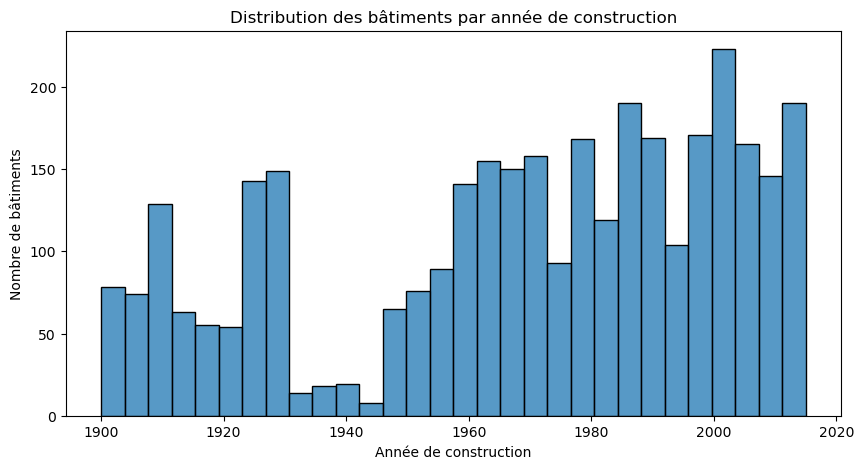

In [8]:
# Histogramme de YearBuilt par décennie
plt.figure(figsize=(10,5))
sns.histplot(data['YearBuilt'], bins=30, kde=False)
plt.title("Distribution des bâtiments par année de construction")
plt.xlabel("Année de construction")
plt.ylabel("Nombre de bâtiments")
plt.show()

Le graphique ci-dessus met en évidence la structure temporelle du parc immobilier non résidentiel de Seattle :
Une forte activité récente : La majorité des bâtiments ont été construits après 1950, avec un pic d'activité majeur autour des années 2000.
L'impact de l'histoire : On observe un creux marqué entre 1930 et 1945, correspondant à la Grande Dépression et à la Seconde Guerre mondiale, périodes où la construction civile était quasiment à l'arrêt.
Cette distribution est cruciale car l'année de construction est un indicateur indirect de la performance thermique (matériaux, isolation, systèmes de chauffage) et des normes réglementaires en vigueur au moment de l'édification.


###  3. Analyses des émissions par époque

L’impact de l’époque de construction sur les émissions est analysé à l’aide de :

- **TotalGHGEmissions moyen** par *Era* (barplot)
- **GHGEmissionsIntensity moyenne** par *Era* (barplot)  
  > Indicateur plus pertinent car il contrôle la taille des bâtiments
- **Boxplots** : distribution de *GHGEmissionsIntensity* par *Era*
- **Test statistique (ANOVA)** :  
  Les moyennes d’intensité d’émissions diffèrent-elles significativement entre les époques ?

C:\Users\USER\AppData\Local\Temp\ipykernel_38864\2054576368.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Era', y='TotalGHGEmissions', data=data, estimator=np.mean, ci=None)


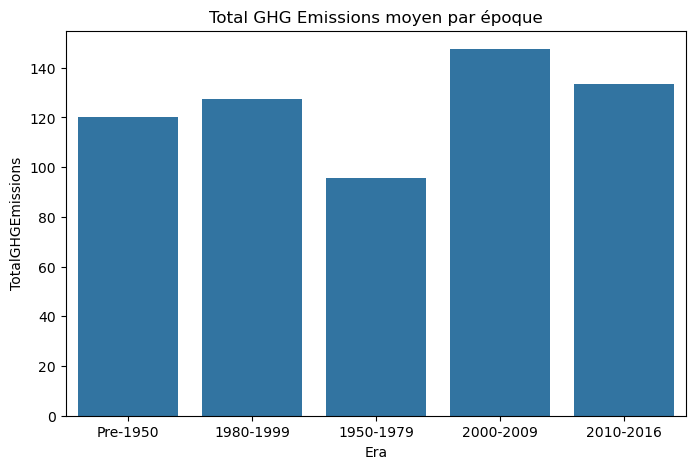

In [9]:
# TotalGHGEmissions moyen par Era
plt.figure(figsize=(8,5))
sns.barplot(x='Era', y='TotalGHGEmissions', data=data, estimator=np.mean, ci=None)
plt.title("Total GHG Emissions moyen par époque")
plt.show()

Analyse des émissions moyennes de CO₂ par époque de constructionCe graphique compare les émissions totales moyennes de gaz à effet de serre ($TotalGHGEmissions$) en fonction des grandes périodes de construction du parc immobilier.Le pic des années 2000 : Contre-intuitivement, les bâtiments construits entre 2000 et 2009 présentent les émissions moyennes les plus élevées. Cela peut s'expliquer par la construction de structures plus vastes (bureaux massifs, centres de données) qui, malgré une meilleure efficacité au $m^2$, consomment davantage au global.L'efficacité relative des années 1950-1979 : Cette période affiche les émissions moyennes les plus basses. Il serait intéressant de vérifier si cela correspond à des bâtiments de plus petite taille ou à des usages moins énergivores.Stabilité des bâtiments anciens : Les constructions Pre-1950 et 1980-1999 présentent des niveaux d'émissions similaires. Pour les plus anciens, cela reflète souvent un besoin de rénovation énergétique important.Amélioration récente (2010-2016) : On observe une légère baisse des émissions par rapport à la décennie précédente, signe probable de l'impact positif des nouvelles réglementations environnementales plus strictes à Seattle.

L'époque de construction ne suit pas une tendance linéaire simple (du plus vieux au plus polluant). Le modèle de machine learning devra donc croiser cette donnée avec la surface totale (GFA) et l'usage du bâtiment pour prédire précisément les émissions.

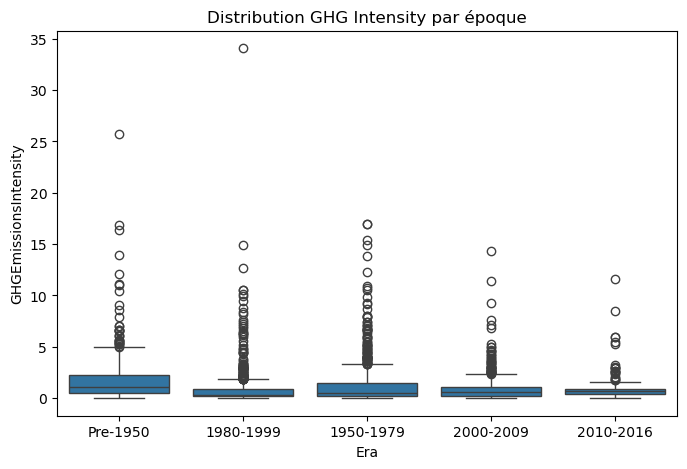

In [10]:
# Boxplot de GHGEmissionsIntensity par Era
plt.figure(figsize=(8,5))
sns.boxplot(x='Era', y='GHGEmissionsIntensity', data=data)
plt.title("Distribution GHG Intensity par époque")
plt.show()

Analyse de l'intensité des émissions ($GHGEmissionsIntensity$) par époqueCe boxplot révèle l'efficacité énergétique intrinsèque des bâtiments selon leur période de construction :Une meilleure efficacité pour les bâtiments récents : Les médianes (traits horizontaux au milieu des boîtes bleues) sont globalement plus basses pour les constructions d'après 1980. Les bâtiments les plus récents (2010-2016) montrent l'intensité la plus faible et la plus homogène.Le poids de l'ancienneté : La période Pre-1950 affiche la médiane la plus élevée. Cela confirme que, proportionnellement à leur surface, les bâtiments historiques sont les plus polluants, probablement en raison d'une isolation thermique moins performante.Présence d'outliers (points isolés) : On observe de nombreux points extrêmes dans toutes les catégories, particulièrement pour la période 1980-1999. Cela indique que dans chaque époque, certains bâtiments ont des comportements atypiques (ex: centres de données ou sites industriels) qui émettent massivement malgré leur âge.Contraste avec les émissions totales : Alors que les années 2000-2009 avaient les émissions totales les plus hautes (graphique précédent), ce boxplot montre que leur intensité est faible. Cela prouve que ces bâtiments sont grands mais efficaces.Conclusion pour le projet : L'intensité des émissions est une cible beaucoup plus stable pour comparer la performance énergétique. L'usage du bâtiment (PrimaryPropertyType) sera certainement la variable clé pour expliquer les valeurs extrêmes (outliers) observées ici .

### 4. Visualisation temporelle continue
Pour dépasser l’approche catégorielle :

- **Scatter plot** : *TotalGHGEmissions* vs *YearBuilt*
- Ajout d’une **courbe de tendance LOWESS** afin de capturer les relations non linéaires


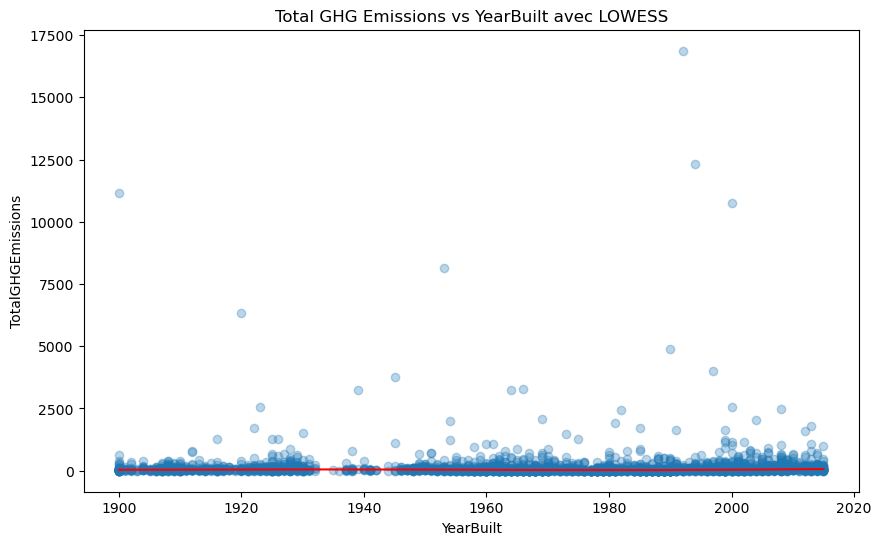

In [11]:
# Scatter plot avec LOWESS
plt.figure(figsize=(10,6))
lowess_smoothed = lowess(data['TotalGHGEmissions'], data['YearBuilt'], frac=0.3)
plt.scatter(data['YearBuilt'], data['TotalGHGEmissions'], alpha=0.3)
plt.plot(lowess_smoothed[:,0], lowess_smoothed[:,1], color='red')
plt.title("Total GHG Emissions vs YearBuilt avec LOWESS")
plt.xlabel("YearBuilt")
plt.ylabel("TotalGHGEmissions")
plt.savefig("total.png", dpi=300, bbox_inches="tight")
plt.show()


Ce graphique de dispersion croisant YearBuilt et TotalGHGEmissions apporte une vision plus fine que les moyennes par époque :

Une tendance globale stable : La ligne rouge (courbe LOWESS) reste presque plate et proche de zéro sur tout l'axe temporel. Cela indique que pour la grande majorité du parc immobilier, l'année de construction seule n'est pas un prédicteur linéaire des émissions totales.

Identification visuelle des valeurs extrêmes (Outliers) : Le graphique met en évidence des points isolés culminant entre 5 000 et plus de 15 000 tonnes de CO2eq, notamment autour de 1900, 1950, et surtout entre 1990 et 2010. Ces bâtiments "super-émetteurs" tirent les moyennes vers le haut, mais ne sont pas représentatifs de la masse.

Concentration dans le temps : On remarque une densité de points beaucoup plus forte après 1950, ce qui confirme l'expansion du parc immobilier de Seattle déjà observée sur l'histogramme de distribution.

Le "Gap" historique : L'absence de points entre 1930 et 1945 est ici très visible, illustrant l'arrêt quasi-total des chantiers durant cette période.

La linéarité entre l'âge et les émissions totales est quasi inexistante à l'échelle globale. Pour obtenir des prédictions précises, le modèle devra impérativement s'appuyer sur des variables de volume (comme la surface PropertyGFATotal) et d'usage, car ce sont probablement ces facteurs qui expliquent pourquoi certains bâtiments récents émettent 100 fois plus que la moyenne de leur époque.

# Section 1 : Impact de la certification ENERGYSTAR dans le temps



L’objectif de cette section est de **comprendre si la certification ENERGYSTAR a eu un effet différentiel selon les époques de construction**.  
L’hypothèse principale est que **la certification est plus fréquente et plus efficace sur les bâtiments récents**, mais pourrait avoir un effet cumulatif sur les bâtiments plus anciens.


### 1. Analyses générales
- **Proportion de bâtiments certifiés** (ENERGYSTARScore non-NaN) par *Era*  
  > Permet de vérifier l’hypothèse selon laquelle les bâtiments récents sont plus souvent certifiés.



### 2. Comparaison des émissions certifiés vs non-certifiés
- Pour chaque *Era*, comparer **GHGEmissionsIntensity** : certifiés vs non-certifiés  
- **Boxplot** : GHGIntensity par *Era*, avec `hue=Has_ENERGYSTAR`  
- **Test statistique** :  
  L'effet de la certification est-il plus fort pour les vieux bâtiments (marge d'amélioration plus grande) ?



### 3. Analyse selon l’ancienneté de la certification
- Variable **YearsENERGYSTARCertified** : depuis combien de temps les bâtiments sont certifiés  
- Analyses :
  - Distribution de YearsENERGYSTARCertified
  - Relation : GHGEmissionsIntensity vs YearsENERGYSTARCertified  
  > Hypothèse : plus un bâtiment est certifié depuis longtemps, plus ses émissions sont faibles (effet cumulatif des améliorations)




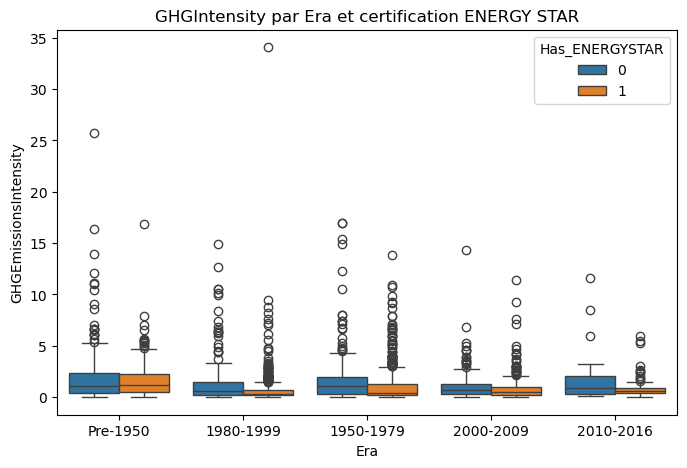

In [12]:
# Comparaison GHGIntensity certifié vs non certifié
plt.figure(figsize=(8,5))
sns.boxplot(x='Era', y='GHGEmissionsIntensity', hue='Has_ENERGYSTAR', data=data)
plt.title("GHGIntensity par Era et certification ENERGY STAR")
plt.show()


Ce graphique compare l'intensité des émissions ($GHGEmissionsIntensity$) entre les bâtiments certifiés (orange) et non certifiés (bleu) à travers les différentes époques :Impact clair de la certification : Pour toutes les périodes de construction (excepté les bâtiments d'avant 1950), les bâtiments certifiés ENERGY STAR présentent une intensité d'émissions médiane nettement plus faible. La certification est donc un indicateur robuste de performance réelle.Réduction de la variabilité : Les boîtes oranges sont non seulement plus basses, mais aussi beaucoup plus "écrasées". Cela signifie que la certification garantit une certaine homogénéité de performance et limite les mauvaises surprises énergétiques.L'exception des bâtiments historiques (Pre-1950) : Pour les bâtiments les plus anciens, la différence entre certifiés et non certifiés est beaucoup moins marquée. Cela suggère que même avec une gestion rigoureuse, la structure physique ancienne du bâtiment limite les gains d'intensité possibles.Efficacité maximale des bâtiments récents certifiés : Les groupes certifiés des périodes 2000-2009 et 2010-2016 affichent les intensités les plus basses de tout le parc immobilier.

Ce graphique démontre que la variable Has_ENERGYSTAR (ou le score lui-même) possède un fort pouvoir prédictif. Elle permet de distinguer, au sein d'une même époque, les bâtiments "vertueux" des autres.Note stratégique : Comme le score ENERGY STAR est complexe à obtenir pour la ville, son intégration dans votre modèle final permettra de quantifier précisément "l'erreur de prédiction" que l'on commet si l'on ne possède pas cette information.

# Section 2 : Cartographie spatiale des émissions

L’objectif de cette section est de **visualiser la distribution géographique des émissions de GHG dans Seattle** et d’identifier les zones les plus émettrices.



### 1. Visualisation de base
- **Scatter plot** : Longitude (x) vs Latitude (y), coloré par TotalGHGEmissions  
- Palette de couleurs divergente : bleu = faible, rouge = élevé  
- Taille des points proportionnelle à PropertyGFABuilding(s) (double encoding)  

**Interprétations visuelles :**
- Downtown : concentration de grandes tours, donc hotspot attendu  
- Zones périphériques : bâtiments plus dispersés, émissions plus faibles



### 2. Heatmap géographique
- Utiliser `folium` ou `seaborn` pour créer une heatmap de densité d'émissions  
- Overlay sur une carte de Seattle  
- Identifier visuellement les zones à forte concentration



### 3. Statistiques spatiales
- Calculer la **densité d’émissions par zone géographique** (si grille définie)  
- Identifier les **hotspots** : zones avec GHG moyen > percentile 90  

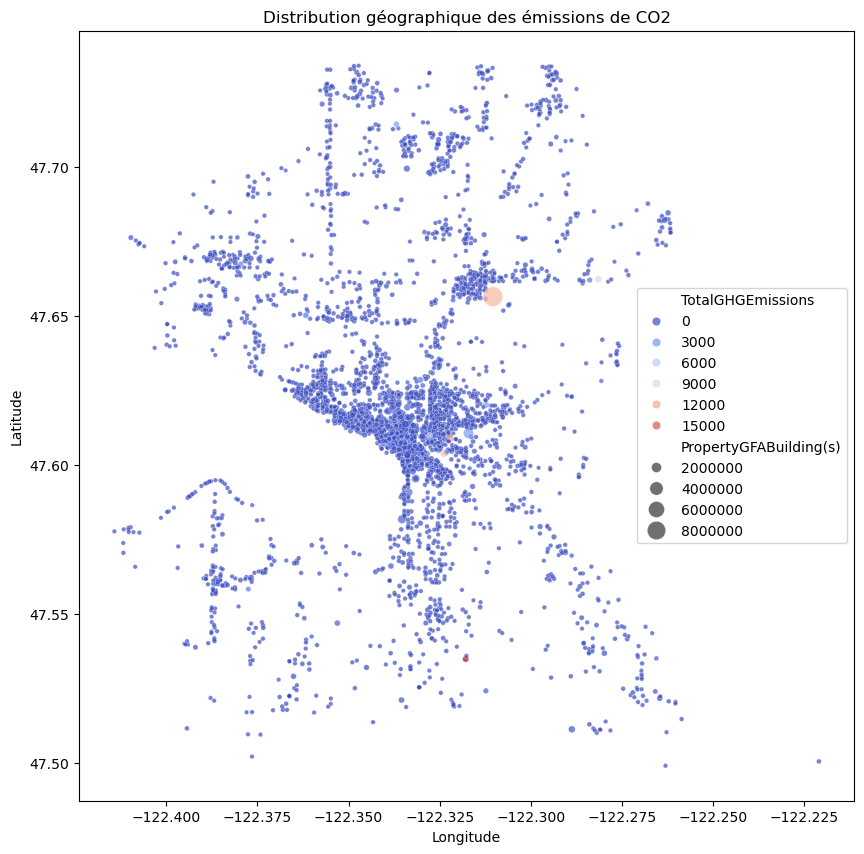

In [13]:
# Scatter plot géographique
plt.figure(figsize=(10,10))
sns.scatterplot(x='Longitude', y='Latitude', hue='TotalGHGEmissions',
                size='PropertyGFABuilding(s)', sizes=(10,200),
                data=data, palette="coolwarm", alpha=0.7)
plt.title("Distribution géographique des émissions de CO2")
plt.savefig("geo.png", dpi=300, bbox_inches="tight")
plt.show()


## Analyse de la distribution géographique des émissions de CO₂

Cette cartographie (Latitude vs Longitude) permet de visualiser l'empreinte environnementale des bâtiments à travers la ville de Seattle :

Forte concentration centrale : On observe une densité très élevée de bâtiments dans la zone centrale (Downtown), correspondant aux pôles d'activité économique. Cependant, la majorité de ces points sont de petite taille et de couleur bleue, indiquant des émissions individuelles modérées.

Identification des "Super-Émetteurs" : Les points les plus larges et de couleur claire/orangée représentent les bâtiments ayant à la fois une grande surface au sol (PropertyGFABuilding(s)) et des émissions totales élevées. Ces points sont dispersés mais souvent situés à proximité des axes principaux ou de zones industrielles spécifiques.

Corrélation Taille/Émissions : Visuellement, la taille des points (surface) semble fortement corrélée à l'intensité de la couleur (émissions totales). Cela confirme que la taille du bâtiment est l'un des facteurs prédictifs les plus déterminants pour votre futur modèle.

Zones de priorité publique : Cette vue permet de cibler géographiquement les quartiers où des interventions de rénovation énergétique groupées auraient le plus d'impact sur la réduction globale des gaz à effet de serre de la ville.

In [1]:
# Filtrer les lignes valides pour la heatmap
heat_data_clean = data.dropna(subset=['Latitude', 'Longitude', 'TotalGHGEmissions'])

# Créer la liste pour HeatMap
heat_data = [[row['Latitude'], row['Longitude'], row['TotalGHGEmissions']] 
             for index, row in heat_data_clean.iterrows()]

# Créer la carte
m = folium.Map(location=[heat_data_clean['Latitude'].mean(), heat_data_clean['Longitude'].mean()], zoom_start=11)

# Ajouter la heatmap
HeatMap(heat_data, radius=15).add_to(m)

# Sauvegarder
m.save("ghg_heatmap.html")


NameError: name 'data' is not defined

In [19]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

# Filtrer les lignes valides
heat_data_clean = data.dropna(subset=['Latitude', 'Longitude', 'TotalGHGEmissions'])

# Préparer les données pour la heatmap
heat_data = [[row['Latitude'], row['Longitude'], row['TotalGHGEmissions']] 
             for index, row in heat_data_clean.iterrows()]

# Créer la carte centrée sur Seattle
m = folium.Map(location=[heat_data_clean['Latitude'].mean(), 
                         heat_data_clean['Longitude'].mean()], zoom_start=11)

# Ajouter la heatmap
HeatMap(heat_data, radius=15).add_to(m)

# Afficher dans le notebook
display(m)


## Analyse de la Heatmap des émissions de CO₂

Cette carte de chaleur, générée à partir des coordonnées géographiques et pondérée par la variable TotalGHGEmissions, offre une perspective visuelle directe sur la densité carbone de Seattle :

   . *L'épicentre du Downtown (Point Chaud)* : La zone rouge vif située au centre correspond au quartier des affaires (Downtown). C'est le foyer principal d'émissions de la ville. Cela s'explique par la densité extrême de gratte-ciels et de grands bâtiments commerciaux qui, bien que parfois efficaces par $m^2$, génèrent un volume total de CO₂ massif en raison de leur taille.
   
   .  *Corridors d'activité Nord-Sud* : On observe des zones "chaudes" (jaunes et orangées) s'étirant le long des axes de transport et de développement principaux. Le nord de Seattle présente plusieurs foyers diffus, tandis que le sud montre des points de concentration vers les zones industrielles et à proximité du Boeing Field.
   
   .  *Hétérogénéité des quartiers* : Les zones bleues et vertes indiquent une densité d'émissions beaucoup plus faible. Cela correspond généralement à des zones de transition ou des quartiers où les bâtiments non résidentiels sont plus petits et plus dispersés (écoles de quartier, petits commerces).
   
   .  *Aide à la décision publique* : Contrairement à la carte de dispersion précédente, la Heatmap permet de voir l'effet cumulé. Pour la ville de Seattle, cela désigne visuellement les quartiers où des infrastructures de réseaux de chaleur ou des programmes de rénovation urbaine à grande échelle auraient l'impact le plus significatif.
   
En combinant cette Heatmap avec la carte de distribution précédente, nous arrivons à une conclusion clé : les émissions de CO₂ ne sont pas uniformément réparties. Elles sont le résultat d'un mélange entre densité urbaine (nombreux petits émetteurs au même endroit) et présence de mégastructures (un seul point très chaud).


# Section 3 : Analyse par quartier (Neighborhood)

L’objectif de cette section est de **comprendre les disparités inter-quartiers à Seattle** et d’identifier les quartiers “high performers” vs “low performers”.



### 1. Analyses descriptives
- Nombre de bâtiments par Neighborhood : barplot (top 20 quartiers)  
- TotalGHGEmissions moyen par Neighborhood : barplot horizontal (top 20)  
- GHGEmissionsIntensity moyen par Neighborhood : barplot (pour contrôler la taille des bâtiments)



### 2. Visualisations
- **Boxplot** : GHGEmissionsIntensity par Neighborhood (top 15 quartiers)  
- Tri par **médiane décroissante**  
- Identification des quartiers **“high performers”** (émissions faibles) vs **“low performers”** (émissions élevées)

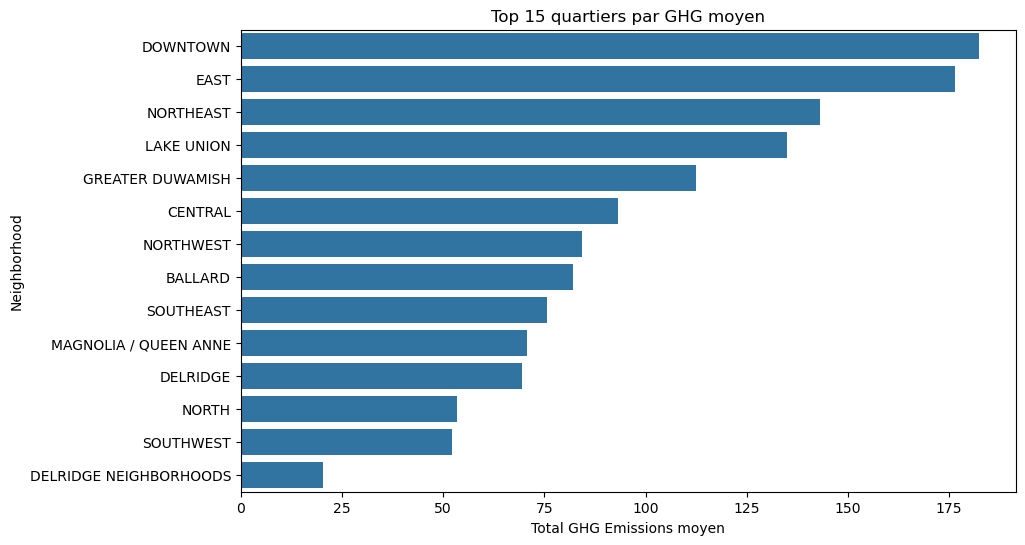

In [15]:
# Analyses par Neighborhood
# Nettoyage des noms de quartiers
data['Neighborhood'] = (
    data['Neighborhood']
    .astype(str)          # sécurité
    .str.strip()          # supprime espaces début/fin
    .str.upper()          # uniformise la casse
)


top_neigh = data.groupby('Neighborhood')['TotalGHGEmissions'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_neigh.values, y=top_neigh.index)
plt.title("Top 15 quartiers par GHG moyen")
plt.xlabel("Total GHG Emissions moyen")
plt.savefig("top.png", dpi=300, bbox_inches="tight")
plt.show()

## Analyse finale du Top 15 des quartiers par émissions moyennes de CO₂  

Le graphique ci-dessus présente le classement  des quartiers de Seattle selon leurs émissions moyennes de gaz à effet de serre, après nettoyage et standardisation des données de localisation.

### Pôles d’émissions majeurs
Les quartiers **DOWNTOWN** et **EAST** se confirment comme les zones les plus émettrices. Cette domination s’explique par une forte concentration de bâtiments de grande hauteur, de complexes hospitaliers et universitaires, ainsi que d’infrastructures tertiaires à forte intensité énergétique. Ces résultats sont cohérents avec les hotspots observés lors de l’analyse cartographique.

### Fiabilité accrue des données
La correction des redondances (fusion de labels tels que *“Delridge”* et *“DELRIDGE”*) permet désormais d’obtenir une estimation fiable des émissions moyennes par quartier.  
On observe que les quartiers plus résidentiels ou périphériques, comme **SOUTHWEST** ou **DELRIDGE NEIGHBORHOODS**, présentent un impact moyen par bâtiment nettement inférieur, pouvant aller jusqu’à **huit fois moins** que celui du centre-ville.

### Ciblage prioritaire pour l’action publique
Ce classement met clairement en évidence que les **cinq premiers quartiers** concentrent une part disproportionnée des émissions liées aux bâtiments. D’un point de vue stratégique, des politiques de rénovation énergétique ciblées sur ces zones auraient un **effet de levier bien plus important** que des mesures uniformes appliquées à l’ensemble du territoire urbain.


Cette analyse  met en évidence plusieurs enseignements clés :

- **Influence de la taille des bâtiments**  
  La surface construite constitue le principal déterminant des émissions totales : les grands bâtiments concentrent mécaniquement une part importante des émissions.

- **Performance temporelle des bâtiments**  
  Les bâtiments récents sont en moyenne plus performants énergétiquement par m², mais leur taille plus importante tend à compenser une partie des gains d’efficacité.

- **Valeur ajoutée de la certification ENERGY STAR**  
  Le score ENERGY STAR apparaît comme un excellent indicateur discriminant de performance énergétique, notamment pour comparer des bâtiments de tailles similaires.

- **Concentration géographique des émissions**  
  Les émissions sont fortement localisées dans l’hyper-centre urbain et dans les pôles technologiques et institutionnels, confirmant l’existence de disparités territoriales marquées.




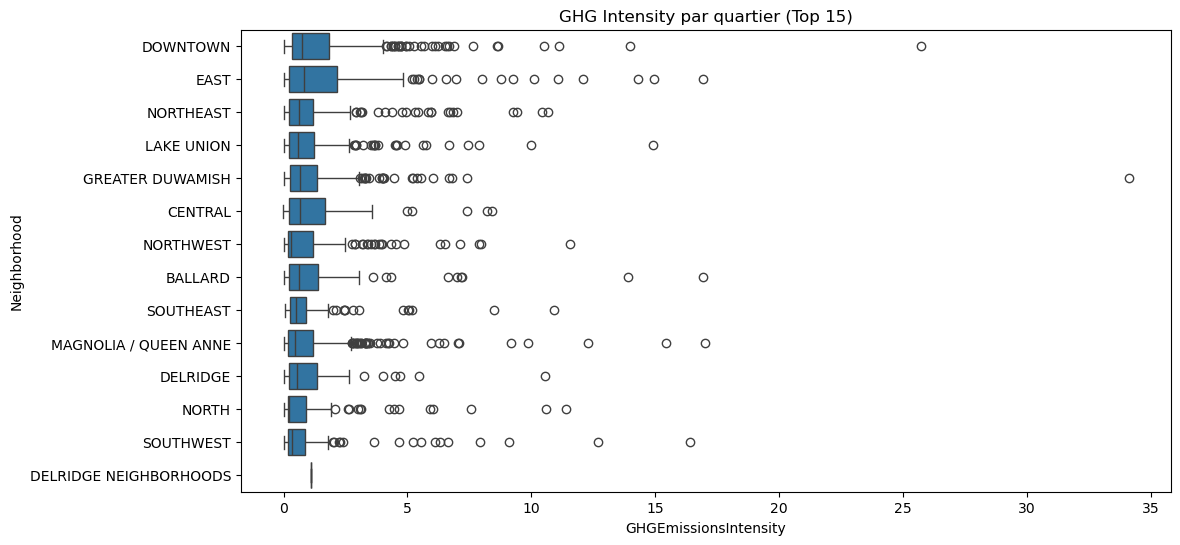

In [16]:
# Boxplot GHGIntensity par quartier
top_neigh_list = top_neigh.index.tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x='GHGEmissionsIntensity', y='Neighborhood', data=data[data['Neighborhood'].isin(top_neigh_list)],
            order=top_neigh_list)
plt.title("GHG Intensity par quartier (Top 15)")
plt.savefig("top_intensite.png", dpi=300, bbox_inches="tight")
plt.show()

## Analyse de l’intensité des émissions par quartier  
*(GHGEmissionsIntensity)*

Ce graphique  analyse l’intensité des émissions de gaz à effet de serre par quartier. Contrairement aux émissions totales, cet indicateur permet d’évaluer la **performance énergétique relative des bâtiments**, indépendamment de leur taille.

### Hétérogénéité des performances énergétiques
Bien que le quartier **DOWNTOWN** présente les émissions totales moyennes les plus élevées, sa **médiane d’intensité des émissions** reste comparable à celle de plusieurs autres quartiers. Cela indique que la forte empreinte carbone du centre-ville est principalement due à la **densité et à la taille des bâtiments**, plutôt qu’à une inefficacité énergétique généralisée.

### Identification des quartiers à performance sensible
Certains quartiers, notamment **EAST** et **CENTRAL**, affichent :
- des médianes légèrement plus élevées ;
- une dispersion plus importante des valeurs.

Cette configuration suggère un parc immobilier plus hétérogène et, en moyenne, **plus énergivore par m²**. Ces zones peuvent refléter une combinaison de bâtiments anciens, d’usages intensifs ou de rénovations incomplètes.

### Alerte sur les outliers extrêmes
Des valeurs aberrantes (outliers) très élevées, dépassant des intensités de **25 à 30**, sont observées principalement dans les quartiers **DOWNTOWN** et **GREATER DUWAMISH**.  
Ces bâtiments représentent des **cibles prioritaires pour des audits énergétiques**, car ils présentent un niveau d’émissions anormalement élevé relativement à leur surface.

### Stabilité énergétique des zones périphériques
Les quartiers périphériques tels que **DELRIDGE NEIGHBORHOODS** montrent :
- des intensités faibles ;
- une très faible dispersion des valeurs.

Cela suggère un parc immobilier plus récent, des bâtiments de petite taille ou des usages moins énergivores (petits commerces, entrepôts peu chauffés, bâtiments résidentiels légers).

### Conclusion 
Cette analyse met en évidence que la réduction efficace des émissions de CO₂ à Seattle ne dépend pas uniquement de la localisation géographique des bâtiments, mais également de leur **comportement énergétique intrinsèque**.  
Un modèle prédictif pertinent devra être capable d’identifier ces **bâtiments atypiques (outliers)** afin d’orienter les politiques publiques vers des actions ciblées et à fort impact.


# Section 4: Infrastructure énergétique - L'utilisation de SteamUse

L’objectif de cette section est de **comprendre la distribution du chauffage urbain à Seattle et son impact sur les émissions de GHG**.  
L’hypothèse principale est que **SteamUse est concentré dans Downtown**, où l’infrastructure centralisée est installée.


### 1. Analyses générales
- Création d’une variable **Has_Steam** :  
- **Proportion de bâtiments utilisant SteamUse** par rapport à l’ensemble du parc



### 2. Distribution géographique
- **Scatter plot** : Latitude vs Longitude, coloré par Has_Steam  
- Hypothèse : Downtown présente la plus forte concentration de bâtiments desservis



### 3. Impact sur les émissions
- Comparer **GHGEmissionsIntensity** : bâtiments avec Steam vs sans Steam  
- **Boxplot** : GHGIntensity par Has_Steam  
- **Test statistique** : différence significative ?



### 4. Analyse par quartier
- Proportion de bâtiments avec Steam par Neighborhood  
- Identification des quartiers desservis par le réseau de chauffage urbain  

**Contexte Seattle :**
- Seattle Steam Company dessert principalement Downtown et certains quartiers adjacents  
- Système ancien (début 1900s), utilise des déchets thermiques de centrales  
- Impact carbone dépend de la source d’énergie utilisée



2026-01-06 00:56:49,534 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-06 00:56:49,574 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


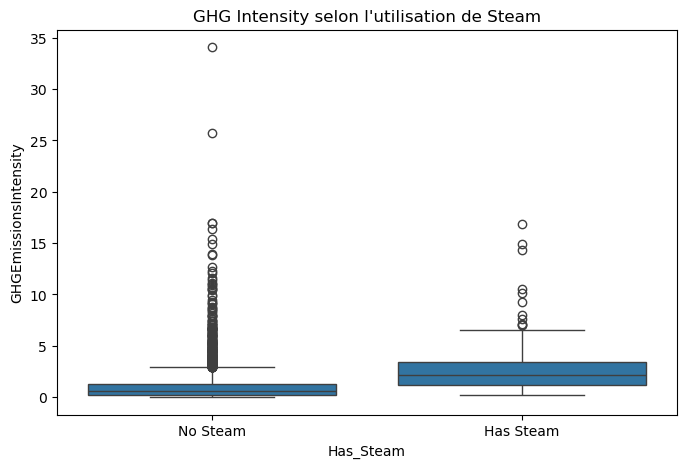

In [17]:

plt.figure(figsize=(8,5))
sns.boxplot(x='Has_Steam', y='GHGEmissionsIntensity', data=data)
plt.title("GHG Intensity selon l'utilisation de Steam")
plt.xticks([0,1], ['No Steam','Has Steam'])
plt.show()


## Analyse de l’intensité des émissions selon l’utilisation du chauffage urbain (Steam)

Ce boxplot compare l’intensité des émissions de gaz à effet de serre  
*(GHGEmissionsIntensity)* entre les bâtiments raccordés au réseau de vapeur de Seattle et ceux qui ne l’utilisent pas.

### Impact significatif de la source d’énergie
Les résultats montrent très clairement que les bâtiments utilisant le réseau de **vapeur (Steam)** présentent une **intensité d’émissions médiane nettement plus élevée** que les bâtiments non raccordés.  
La vapeur, souvent produite à partir de combustibles fossiles et distribuée via des infrastructures anciennes, apparaît ici comme une **source majeure d’émissions de CO₂ par m²**.

### Performance énergétique des bâtiments sans vapeur
Le groupe **No Steam** affiche :
- une médiane d’intensité proche de zéro ;
- une dispersion beaucoup plus faible.

Cela suggère que les bâtiments utilisant principalement l’électricité (à faible contenu carbone à Seattle) ou le gaz naturel, souvent plus récents ou mieux régulés, sont **structurellement plus performants énergétiquement**.

### Présence de valeurs atypiques (outliers)
Malgré de meilleures performances globales, le groupe **No Steam** contient plusieurs **outliers extrêmes**, avec des intensités dépassant parfois 30.  
Ces observations indiquent que d’autres facteurs — tels que des usages industriels intensifs, une isolation défaillante ou des équipements obsolètes — peuvent entraîner une pollution très élevée, même en l’absence de chauffage urbain.

### Implications pour la modélisation prédictive
L’utilisation du réseau de vapeur constitue une **variable explicative clé** pour la prédiction des émissions :
- elle est fortement discriminante ;
- elle est disponible en amont dans les données administratives du bâtiment ;
- elle reflète directement le type d’infrastructure énergétique utilisée.

Cette variable devra donc être **impérativement intégrée** dans le modèle final afin de capter l’asymétrie structurelle des sources d’émissions à Seattle.


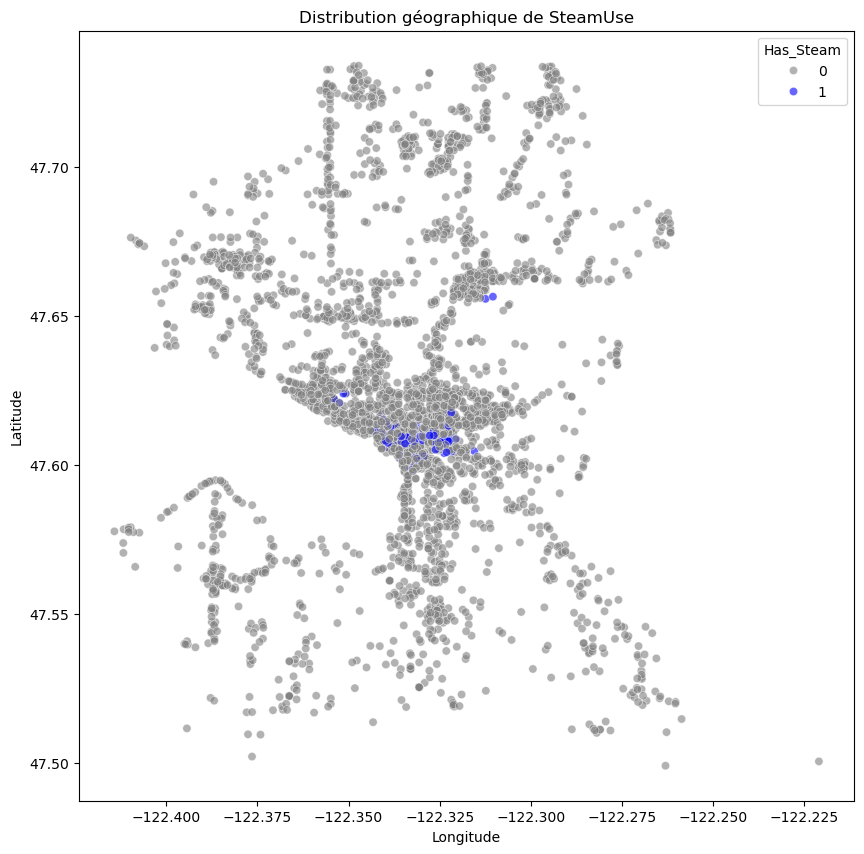

In [18]:
# Distribution géographique Steam
plt.figure(figsize=(10,10))
sns.scatterplot(x='Longitude', y='Latitude', hue='Has_Steam',
                data=data, alpha=0.6, palette=["grey","blue"])
plt.title("Distribution géographique de SteamUse")
plt.savefig("stream.png", dpi=300, bbox_inches="tight")
plt.show()

## Analyse de la distribution géographique de l’utilisation de la vapeur (Steam)

Cette carte superpose l’utilisation du réseau de vapeur à la géographie de Seattle et apporte un éclairage déterminant sur l’origine des émissions observées précédemment.

### Hyper-localisation du réseau de vapeur
Les bâtiments utilisant la vapeur (*Has_Steam = 1*, points bleus) sont **quasi exclusivement concentrés dans une zone très restreinte**, correspondant au **Downtown** et à ses environs immédiats (notamment *First Hill*).  
Cette concentration confirme que le chauffage urbain à la vapeur repose sur une **infrastructure historique, centralisée et spatialement très limitée**.

### Explication du « point chaud » central
Cette observation permet de comprendre pourquoi le **Downtown domine systématiquement les analyses d’émissions** :
- ce n’est pas uniquement un effet de taille ou de densité des bâtiments ;
- c’est aussi la **seule zone massivement raccordée au réseau de vapeur**, identifié précédemment comme une source d’émissions particulièrement intense.

Ainsi, le hotspot géographique observé dans les heatmaps résulte d’une **combinaison de facteurs structurels** : grands bâtiments + infrastructure énergétique fortement carbonée.

### Absence du réseau en périphérie
Dans les quartiers périphériques (Nord, Sud, Ouest), la quasi-totalité des bâtiments apparaît en **Has_Steam = 0**.  
Ces zones reposent majoritairement sur :
- l’électricité (très faiblement carbonée à Seattle),
- ou le gaz naturel.

Cela explique les **intensités d’émissions nettement plus faibles** observées dans les analyses par quartier et par district administratif.

### Une contrainte structurelle pour la neutralité carbone
Cette cartographie met en évidence une contrainte majeure pour la ville de Seattle :  
la trajectoire vers la neutralité carbone passera nécessairement par :
- une **modernisation profonde du réseau de vapeur** existant,
- ou une **transition énergétique ciblée sur les bâtiments du centre-ville**, principaux utilisateurs de cette infrastructure.

Les actions sur le Downtown auront donc un **effet de levier disproportionné** sur la réduction globale des émissions urbaines.


# Section 5 : Contexte climatique et énergétique de Seattle



## 1. Contexte climatique de la ville de Seattle

La ville de Seattle est située dans le nord-ouest des États-Unis, dans une zone fortement influencée par l’océan Pacifique. Elle bénéficie d’un climat tempéré océanique, caractérisé par des hivers relativement doux et humides et par des étés historiquement modérés. Les précipitations sont fréquentes et s’étalent sur une grande partie de l’année, avec une intensité plus marquée durant la période automnale et hivernale. Ce contexte climatique a longtemps contribué à une demande énergétique stable, dominée par les besoins en chauffage et par une consommation électrique relativement constante, tout en limitant les besoins en climatisation.

Cependant, les effets du changement climatique se manifestent de manière de plus en plus visible à Seattle. La ville connaît une augmentation de la fréquence et de l’intensité des vagues de chaleur, ainsi que des épisodes de températures exceptionnellement élevées qui rompent avec les tendances historiques. Ces évolutions modifient progressivement les profils de consommation énergétique, notamment en augmentant la demande en climatisation et en accentuant les pics de consommation électrique. Par ailleurs, la densité urbaine et l’artificialisation des sols favorisent l’apparition d’îlots de chaleur urbains, qui amplifient localement les températures et renforcent les pressions énergétiques et environnementales.

## 2. Contexte énergétique et structure de la consommation

Seattle se distingue par un mix électrique largement dominé par des sources d’énergie à faible intensité carbone, en particulier l’hydroélectricité, qui constitue la principale source de production d’électricité dans la région. Cette spécificité confère à la ville un avantage important en matière de réduction des émissions de CO₂ liées à la consommation électrique. Toutefois, cette situation favorable masque une réalité plus contrastée, car une part significative de l’énergie consommée à l’échelle urbaine repose encore sur des combustibles fossiles, notamment pour le chauffage des bâtiments résidentiels et tertiaires.

Les bâtiments représentent ainsi un poste clé dans le bilan énergétique et carbone de la ville. Les besoins en chauffage, fortement dépendants des conditions climatiques et des caractéristiques du bâti, constituent une source majeure d’émissions lorsque le gaz naturel ou d’autres combustibles fossiles sont utilisés. À cela s’ajoutent les consommations énergétiques liées aux activités économiques et aux services urbains, qui contribuent également aux émissions de CO₂. Malgré la propreté relative du réseau électrique, la structure des usages énergétiques demeure donc un facteur déterminant dans la dynamique globale des émissions.

## 3. Enjeux climatiques et lien avec la prédiction des émissions de CO₂

Face aux défis climatiques actuels, la ville de Seattle s’est engagée dans une stratégie ambitieuse de transition énergétique visant une réduction progressive et durable des émissions de gaz à effet de serre, avec pour objectif l’atteinte de la neutralité carbone à l’horizon 2050. Cette stratégie repose notamment sur l’amélioration de l’efficacité énergétique des bâtiments, l’électrification des usages, la réduction de la dépendance aux combustibles fossiles et la mise en place de politiques publiques incitatives. Ces transformations structurelles influencent directement la relation entre la consommation d’énergie et les émissions de CO₂ observées.

Dans le cadre de ce notebook, l’analyse du contexte climatique et énergétique permet de mieux comprendre les mécanismes sous-jacents aux émissions de CO₂ et d’orienter la modélisation prédictive. Les variables climatiques, les indicateurs de consommation énergétique et les caractéristiques des bâtiments sont mobilisés afin de capturer la complexité de ces interactions. L’objectif est de produire des prédictions robustes et interprétables, tout en identifiant les principaux leviers sur lesquels des actions ciblées pourraient avoir un impact significatif en matière de réduction des émissions et de lutte contre le changement climatique.


# Conclusion génerale 



L'analyse exploratoire spatio-temporelle a permis de dresser un portrait précis des facteurs influençant les émissions de gaz à effet de serre (GES) des bâtiments non résidentiels à Seattle. Voici les principaux enseignements à retenir pour la phase de modélisation :

### 1. Des leviers d'émissions clairement identifiés
L'étude démontre que les émissions ne sont pas distribuées de manière aléatoire mais répondent à des déterminants structurels et techniques majeurs :
* **La Surface (GFA) :** Elle reste le moteur principal du volume global des émissions.
* **Le Réseau de Vapeur (Steam) :** Son utilisation est synonyme d'une intensité carbone nettement plus élevée, représentant une contrainte structurelle pour les bâtiments du centre-ville.
* **La Certification ENERGY STAR :** Elle constitue un indicateur de performance robuste, permettant de distinguer les bâtiments économes des bâtiments inefficaces, indépendamment de leur âge.

### 2. Une hétérogénéité spatio-temporelle marquée
* **Dimension Temporelle :** Si l'intensité carbone diminue globalement pour les constructions les plus récentes, la taille croissante des bâtiments modernes tend à compenser ces gains d'efficacité au niveau des émissions totales.
* **Dimension Spatiale :** Le quartier du **Downtown** concentre l'essentiel des enjeux en raison de sa densité et de son raccordement historique au réseau de vapeur.

### 3. Recommandations pour la modélisation prédictive
Pour répondre à l'objectif métier de prédiction sans utiliser les données de consommation future, les variables suivantes devront être privilégiées :
* **Variables administratives et structurelles :** Type d'usage (`PrimaryPropertyType`), surface totale, année de construction et localisation (quartiers/districts).
* **Variables techniques déclaratives :** Utilisation de la vapeur et statut de certification ENERGY STAR.

### 4. Impact pour la décision publique
Les résultats soulignent que pour atteindre la neutralité carbone d'ici 2050, la ville de Seattle aura un **effet de levier disproportionné** en ciblant prioritairement :
1. Les bâtiments du centre-ville (Downtown).
2. La modernisation ou la transition hors du réseau de vapeur.
3. Les bâtiments à forte intensité mais à faible score ENERGY STAR.

Cette analyse exploratoire pose les bases nécessaires au développement de modèles de machine learning robustes, capables d'anticiper les émissions dès la conception ou la déclaration administrative des bâtiments.